<a href="https://colab.research.google.com/github/Shyamesh/SIT723-24/blob/main/Copy_of_drl_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os

# List of filenames
csv_files = [
    '/content/client1_bbr_full.csv',
    '/content/client1_cubic_full.csv',
    '/content/client1_pcc.csv',
    '/content/client2_bbr_switch_cubic.csv',
    '/content/client2_pcc.csv',
    '/content/client2_pcc_switch_bbr.csv'
]

# Function to extract CCA from the filename
def get_cca_from_filename(filename, switch_time=40):
    if 'switch' in filename:
        if 'bbr_switch_cubic' in filename:
            return 'BBR', 'CUBIC', switch_time
        elif 'pcc_switch_bbr' in filename:
            return 'PCC', 'BBR', switch_time
    elif 'bbr' in filename:
        return 'BBR', None, None
    elif 'cubic' in filename:
        return 'CUBIC', None, None
    elif 'pcc' in filename:
        return 'PCC', None, None
    else:
        return 'UNKNOWN', None, None

# Initialize an empty list to hold DataFrames
dataframes = []

# Loop through the list of CSV files and read each one into a DataFrame
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        if 'Timestamp' not in df.columns:
            print(f"Warning: 'Timestamp' column not found in {file}. Skipping this file.")
            continue
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Ensure Timestamp is in datetime format
        df['time'] = (df['Timestamp'] - df['Timestamp'].min()).dt.total_seconds()  # Create a 'time' column in seconds
        cca1, cca2, switch_time = get_cca_from_filename(file)
        if cca2 is None:
            df['CCA'] = cca1
        else:
            df['CCA'] = [cca1 if t <= switch_time else cca2 for t in df['time']]
        dataframes.append(df)
    else:
        print(f"File not found: {file}")

# Concatenate all DataFrames into a single DataFrame if dataframes list is not empty
if dataframes:
    combined_data = pd.concat(dataframes, ignore_index=True)
    # Save the combined DataFrame to a CSV file
    combined_data.to_csv('/content/combined_data.csv', index=False)
    print("Combined data saved to '/content/combined_data.csv'")
else:
    print("No valid files were found. Please check the file paths and content.")


File not found: /content/client1_bbr_full.csv
Combined data saved to '/content/combined_data.csv'


In [ ]:
# Fill missing values for numerical columns with mean
for col in combined_data.select_dtypes(include=['float64', 'int64']).columns:
    combined_data[col].fillna(combined_data[col].mean(), inplace=True)

# Fill missing values for categorical columns with mode
for col in combined_data.select_dtypes(include=['object']).columns:
    combined_data[col].fillna(combined_data[col].mode()[0], inplace=True)

# Verify if all missing values are handled
missing_values_post = combined_data.isnull().sum()
print("Missing values after handling:")
print(missing_values_post)


Missing values after handling:
Timestamp      0
Throughput     0
LossRate       0
Latency        0
SendingRate    0
time           0
CCA            0
dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for standardization
numerical_cols = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Standardize numerical columns
scaler = StandardScaler()
combined_data[numerical_cols] = scaler.fit_transform(combined_data[numerical_cols])

# Display the first few rows after standardization
print(combined_data.head())


            Timestamp  Throughput   LossRate       Latency  SendingRate  \
0 2024-05-30 07:31:40   -2.063979  16.292751  8.473640e-17    -3.328244   
1 2024-05-30 07:31:41   -0.170823   0.580359  8.473640e-17    -0.282757   
2 2024-05-30 07:31:42    0.504422  -0.011853  8.473640e-17    -0.916587   
3 2024-05-30 07:31:43    1.590342  -0.047357  8.473640e-17    -0.755940   
4 2024-05-30 07:31:44    1.758314  -0.060487  8.473640e-17    -0.867777   

       time    CCA  
0 -1.712318  CUBIC  
1 -1.680774  CUBIC  
2 -1.649230  CUBIC  
3 -1.617685  CUBIC  
4 -1.586141  CUBIC  


In [ ]:
# Replace categorical values with numeric labels
combined_data['CCA'] = combined_data['CCA'].astype('category')
combined_data['CCA'] = combined_data['CCA'].cat.codes

# Impute missing values with the mean of each feature
combined_data.fillna(combined_data.mean(), inplace=True)

# Normalize features if needed (optional)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined_data[['Throughput', 'Latency', 'LossRate', 'SendingRate', 'CCA']] = scaler.fit_transform(combined_data[['Throughput', 'Latency', 'LossRate', 'SendingRate', 'CCA']])


In [ ]:
# Save preprocessed data to a CSV file
combined_data.to_csv('preprocessed_data.csv', index=False)


In [ ]:
# Split the data into training and testing sets
split_index = int(0.8 * len(combined_data))
train_data = combined_data.iloc[:split_index]
test_data = combined_data.iloc[split_index:]


In [ ]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import random
import matplotlib.pyplot as plt
import csv

class CongestionControlEnv(gym.Env):
    def __init__(self, data, thresholds):
        super(CongestionControlEnv, self).__init__()
        self.data = data
        self.thresholds = thresholds
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.current_step = 0
        self.state = None
        self.current_cca = 'default'
        self.available_ccas = ['cca1', 'cca2', 'cca3']

    def reset(self):
        self.current_step = 0
        self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
        self.current_cca = 'default'
        return self.state

    def step(self, action):
        if action == 1:
            best_cca = self.evaluate_best_cca()
            if best_cca != self.current_cca:
                self.current_cca = best_cca
                print(f"Switched to congestion control algorithm: {self.current_cca}")

        self.current_step += 1
        done = self.current_step >= len(self.data)
        if not done:
            self.state = self.data.iloc[self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values
        else:
            self.state = None

        reward = self._calculate_reward(action)
        info = {'action': action, 'cca': self.current_cca}

        return self.state, reward, done, info

    def evaluate_best_cca(self):
        current_state = self.state
        historical_data = self.get_historical_data()

        if historical_data is not None and len(historical_data) > 0:
            combined_state = 0.8 * current_state + 0.2 * np.mean(historical_data, axis=0)
        else:
            combined_state = current_state

        best_cca = self.choose_best_cca_from_evaluation(combined_state)
        return best_cca

    def choose_best_cca_from_evaluation(self, combined_state):
        weights = {'Throughput': 0.7, 'Latency': 0.2, 'LossRate': 0.1}
        cca_scores = {cca: sum(weights[metric] * combined_state[i] for i, metric in enumerate(weights)) for cca in self.available_ccas}
        best_cca = max(cca_scores, key=cca_scores.get)
        return best_cca


    def _calculate_reward(self, action):
        if self.state is None:  # Handle case where state is None
            return 0  # Return zero reward if state is None
        disparities = np.abs(self.state - self.data.iloc[self.current_step-1][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values)
        reward = 0
        if np.any(disparities > self.thresholds):
            reward += np.log10(0.059)  # High disparities reward
        else:
            reward -= np.log10(0.01)  # Low disparities penalty
        if action == 1:
            reward += np.log10(0.05) # Switching penalty
        return reward


    def get_historical_data(self):
        return self.data.iloc[:self.current_step][['Throughput', 'Latency', 'LossRate', 'SendingRate']].values

class DQNAgent:
    def __init__(self, state_shape, action_space):
        self.state_shape = state_shape
        self.action_space = action_space
        self.model = self.build_model()
        self.replay_buffer = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.loss_history = []
        self.accuracy_history = []

    def build_model(self):
        model = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=self.state_shape),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_space, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        act_values = self.model.predict(state_tensor)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        minibatch = random.sample(self.replay_buffer, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state_tensor = tf.convert_to_tensor(next_state, dtype=tf.float32)
                target = reward + self.gamma * np.amax(self.model.predict(next_state_tensor)[0])
            state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
            target_f = self.model.predict(state_tensor)
            target_f[0][action] = target
            history = self.model.fit(state_tensor, target_f, epochs=1, verbose=0)
            self.loss_history.append(history.history['loss'][0])
            self.accuracy_history.append(history.history['accuracy'][0])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


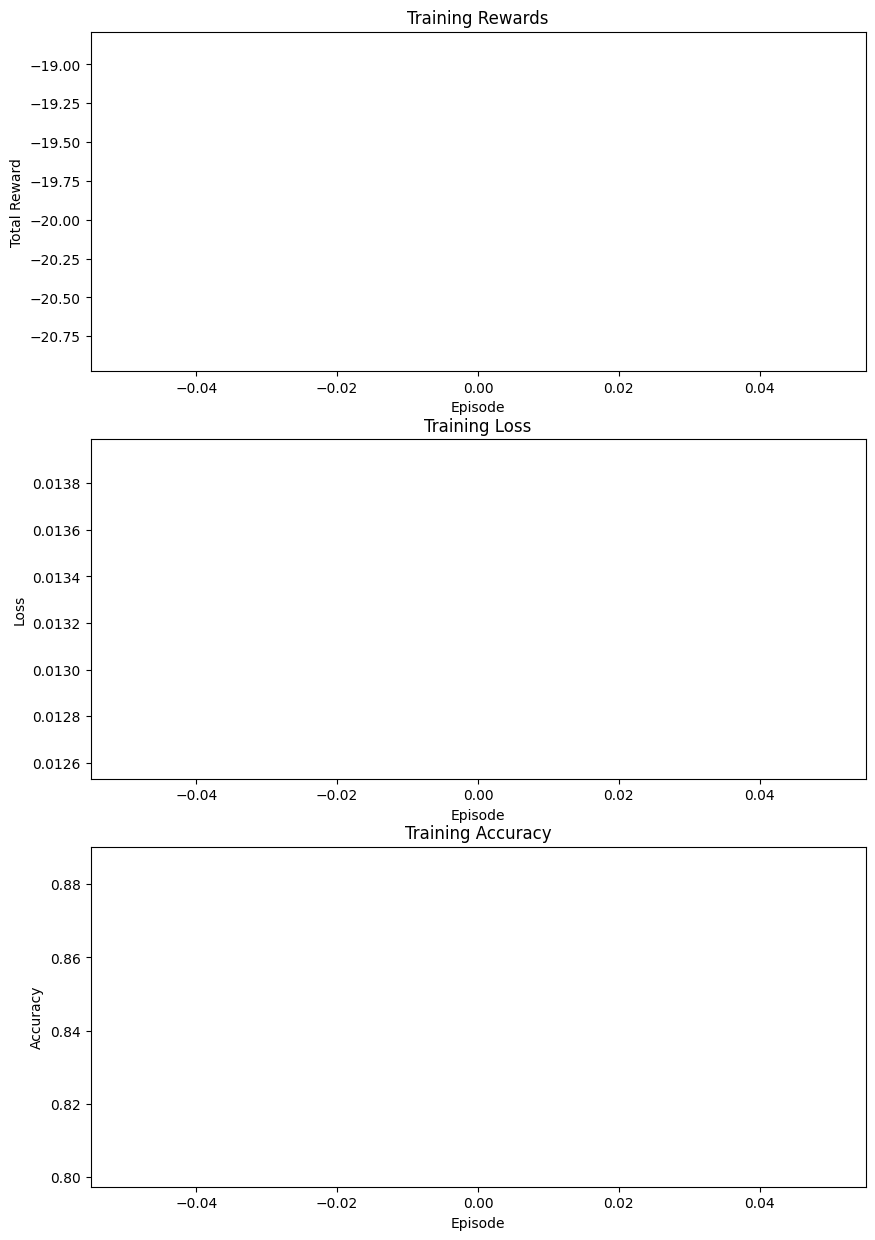

Episode: 1, Total Reward: -19.882521344369856, Loss: 0.013259227394883055, Accuracy: 0.84375
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 2, Total Reward: -18.979431357377916, Loss: 0.006807005754104978, Accuracy: 0.96875
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 3, Total Reward: -21.387671322689766, Loss: 0.00543750242067631, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 4, Total Reward: -19.581491348705875, Loss: 0.02353625536693471, Accuracy: 0.875
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 5, Total Reward: -16.571191392066066, Loss: 0.02826863149948622, Accuracy: 0.5
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 6, Total Reward: -16.872221387730047, Loss: 0.04382834335478947, Accuracy: 0.8125
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 7, Total Reward: -19.280461353041897, Loss: 0.06579543266934706, Accuracy: 0.65625
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 8, Total Reward: -19.581491348705878, Loss: 0.018582085926425407, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 9, Total Reward: -17.77531137472199, Loss: 0.007992925588780508, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 10, Total Reward: -20.484581335697822, Loss: 0.007334423524980593, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 11, Total Reward: -19.280461353041893, Loss: 0.009362638336369855, Accuracy: 0.9375
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 12, Total Reward: -21.688701318353747, Loss: 0.004706404481190418, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 13, Total Reward: -18.678401361713934, Loss: 0.002976475529720801, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 14, Total Reward: -16.872221387730047, Loss: 0.0075528741890593665, Accuracy: 0.96875
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 15, Total Reward: -18.377371366049953, Loss: 0.007141777376482139, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 16, Total Reward: -20.18355134003384, Loss: 0.005761820890256786, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 17, Total Reward: -18.377371366049953, Loss: 0.003066517647535072, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 18, Total Reward: -18.678401361713934, Loss: 0.006375941974965826, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 19, Total Reward: -18.979431357377912, Loss: 0.00928905274764702, Accuracy: 0.96875
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 20, Total Reward: -19.280461353041893, Loss: 0.00851497182762273, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 21, Total Reward: -14.463981422418195, Loss: 0.004890471619734882, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 22, Total Reward: -15.367071409410137, Loss: 0.0033923086806453284, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 23, Total Reward: -15.9691314007381, Loss: 0.002987094962248471, Accuracy: 1.0
1/1 [==============================] - 0s 45ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 24, Total Reward: -18.979431357377916, Loss: 0.003239728264020414, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 25, Total Reward: -17.775311374721987, Loss: 0.006760708538195104, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 26, Total Reward: -15.367071409410139, Loss: 0.003059120269028881, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 27, Total Reward: -15.969131400738101, Loss: 0.0044377112214561976, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 28, Total Reward: -18.07634137038597, Loss: 0.0033913259640527826, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 29, Total Reward: -17.173251383394028, Loss: 0.002612391896326116, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 30, Total Reward: -16.872221387730043, Loss: 0.002113610345310768, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 31, Total Reward: -19.88252134436986, Loss: 0.0028756590931209303, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 32, Total Reward: -15.969131400738103, Loss: 0.0009900868106045846, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 33, Total Reward: -18.07634137038597, Loss: 0.0015748195584706082, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 34, Total Reward: -17.47428137905801, Loss: 0.00193953561998228, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 35, Total Reward: -15.066041413746156, Loss: 0.0012582003127050712, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 36, Total Reward: -13.861921431090233, Loss: 0.0022843613246550376, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 62ms/step


<Figure size 640x480 with 0 Axes>

Episode: 37, Total Reward: -15.06604141374616, Loss: 0.0013110247076069115, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 38, Total Reward: -17.173251383394028, Loss: 0.001542678176659651, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 39, Total Reward: -14.765011418082178, Loss: 0.0015220823280333584, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 40, Total Reward: -17.474281379058006, Loss: 0.00208406110031234, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 41, Total Reward: -17.77531137472199, Loss: 0.000716656935049409, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 42, Total Reward: -16.270161396402084, Loss: 0.0009520465025616431, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 43, Total Reward: -14.765011418082178, Loss: 0.0019036596056134503, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 44, Total Reward: -15.969131400738103, Loss: 0.0007854160179627812, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 45, Total Reward: -17.77531137472199, Loss: 0.0005037412991415469, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 46, Total Reward: -16.571191392066066, Loss: 0.0007622723504461248, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 47, Total Reward: -15.969131400738101, Loss: 0.0007071705350085722, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 48, Total Reward: -15.969131400738101, Loss: 0.000880790294048861, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 49, Total Reward: -14.463981422418197, Loss: 0.0007278510829353824, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 50, Total Reward: -14.463981422418199, Loss: 0.0013886828299323195, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 51, Total Reward: -17.173251383394028, Loss: 0.0007121523212811898, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 52, Total Reward: -15.367071409410139, Loss: 0.0005528251200956902, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 53, Total Reward: -16.270161396402084, Loss: 0.0005720223105143418, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 54, Total Reward: -16.270161396402084, Loss: 0.00013205734934018665, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 55, Total Reward: -17.474281379058006, Loss: 0.00028235953986044393, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 56, Total Reward: -13.560891435426255, Loss: 0.0003164357638625881, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 44ms/step


<Figure size 640x480 with 0 Axes>

Episode: 57, Total Reward: -14.162951426754216, Loss: 0.000882264422607193, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 58, Total Reward: -15.36707140941014, Loss: 0.0005697465005349844, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 59, Total Reward: -13.560891435426255, Loss: 0.0009703747388112305, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 60, Total Reward: -17.173251383394028, Loss: 0.00030246660686117366, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 61, Total Reward: -15.668101405074122, Loss: 0.00016705640853964532, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

Episode: 62, Total Reward: -14.162951426754212, Loss: 0.00025050630784306804, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 63, Total Reward: -15.668101405074118, Loss: 0.00023479862853292843, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 64, Total Reward: -14.463981422418197, Loss: 0.0002701560015339055, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 65, Total Reward: -16.27016139640208, Loss: 0.000328338905007719, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 66, Total Reward: -16.872221387730047, Loss: 0.0004669634206289075, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 67, Total Reward: -13.861921431090234, Loss: 0.0002508284162328067, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 68, Total Reward: -15.367071409410142, Loss: 0.00029274231752030033, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 69, Total Reward: -15.969131400738103, Loss: 0.00023499565125817412, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 70, Total Reward: -14.76501141808218, Loss: 0.00018179796451534003, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 71, Total Reward: -15.066041413746158, Loss: 0.00010467516709677938, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 72, Total Reward: -15.66810140507412, Loss: 0.00012307779338271985, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 73, Total Reward: -15.367071409410137, Loss: 0.00015275795944891257, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 74, Total Reward: -14.765011418082176, Loss: 0.0001722363342394062, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 75, Total Reward: -13.861921431090234, Loss: 0.00012212678217654593, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 76, Total Reward: -14.765011418082178, Loss: 0.00016023698896128202, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 77, Total Reward: -12.958831444098292, Loss: 0.00011334222889169965, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 78, Total Reward: -15.06604141374616, Loss: 0.00022439514075323075, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 79, Total Reward: -15.06604141374616, Loss: 0.00030069855017877956, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 80, Total Reward: -12.958831444098292, Loss: 0.0002605322193298676, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 81, Total Reward: -15.066041413746158, Loss: 0.0001325415453224399, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 82, Total Reward: -16.270161396402084, Loss: 0.00015681679625201284, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 83, Total Reward: -14.463981422418197, Loss: 0.00014593897785175614, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 84, Total Reward: -16.270161396402084, Loss: 0.00011250128820350369, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 85, Total Reward: -13.861921431090233, Loss: 0.00012913556852467423, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 86, Total Reward: -15.668101405074122, Loss: 0.0001476520655216973, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 87, Total Reward: -15.066041413746156, Loss: 0.00015461037519992615, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 88, Total Reward: -14.463981422418197, Loss: 8.41417137680267e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 89, Total Reward: -13.560891435426253, Loss: 0.0001360404489976208, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 90, Total Reward: -14.765011418082178, Loss: 0.0002913240159743147, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 91, Total Reward: -13.259861439762275, Loss: 0.0005860735547287277, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 92, Total Reward: -12.958831444098294, Loss: 0.0005218239962516691, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 93, Total Reward: -14.463981422418197, Loss: 0.0011756189429803499, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 94, Total Reward: -15.367071409410137, Loss: 0.002162806984955523, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 95, Total Reward: -16.27016139640208, Loss: 0.0011040691728796403, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 96, Total Reward: -13.259861439762274, Loss: 0.0020570404693671662, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 97, Total Reward: -15.06604141374616, Loss: 0.0031741827419295987, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 98, Total Reward: -12.657801448434308, Loss: 0.0008873932778241667, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 99, Total Reward: -12.958831444098292, Loss: 0.0006779572944026757, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 100, Total Reward: -15.367071409410139, Loss: 0.00039806074875153863, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 49ms/step


<Figure size 640x480 with 0 Axes>

Episode: 101, Total Reward: -13.560891435426253, Loss: 0.00026274996802388983, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 102, Total Reward: -11.45368146577839, Loss: 0.0004368038991389156, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 103, Total Reward: -13.25986143976227, Loss: 0.00029744563852318606, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

Episode: 104, Total Reward: -12.95883144409829, Loss: 0.0003385775332631624, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

Episode: 105, Total Reward: -12.958831444098289, Loss: 0.00019791914532252264, Accuracy: 1.0
1/1 [==============================] - 0s 63ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 106, Total Reward: -12.65780144843431, Loss: 0.000479636464153943, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 107, Total Reward: -12.356771452770333, Loss: 0.0003296305588560977, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 108, Total Reward: -15.36707140941014, Loss: 0.00015010414409655226, Accuracy: 1.0
1/1 [==============================] - 0s 48ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 109, Total Reward: -13.25986143976227, Loss: 0.00026723670820794077, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 110, Total Reward: -12.958831444098294, Loss: 0.00012727880268315062, Accuracy: 1.0
1/1 [==============================] - 0s 47ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 111, Total Reward: -12.958831444098289, Loss: 0.00030331989733434206, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 112, Total Reward: -14.76501141808218, Loss: 0.0006924880163978742, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 113, Total Reward: -12.055741457106347, Loss: 0.00035582633336517233, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 114, Total Reward: -13.259861439762272, Loss: 0.0003869703630202115, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 115, Total Reward: -14.162951426754216, Loss: 0.00018323536954056863, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 116, Total Reward: -11.15265147011441, Loss: 0.00017006460757329478, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 117, Total Reward: -16.270161396402084, Loss: 0.00017454774798242312, Accuracy: 1.0
1/1 [==============================] - 0s 46ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 118, Total Reward: -12.958831444098289, Loss: 0.0001359270601497542, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 119, Total Reward: -14.765011418082178, Loss: 0.0001707332263694017, Accuracy: 1.0
1/1 [==============================] - 0s 21ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 120, Total Reward: -12.35677145277033, Loss: 0.0001493111249921686, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 121, Total Reward: -13.560891435426255, Loss: 0.00012690710984669673, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 122, Total Reward: -16.872221387730047, Loss: 7.216319631986323e-05, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 59ms/step


<Figure size 640x480 with 0 Axes>

Episode: 123, Total Reward: -12.65780144843431, Loss: 5.2980323085149994e-05, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 124, Total Reward: -12.055741457106347, Loss: 7.968081583709097e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 125, Total Reward: -12.657801448434308, Loss: 0.00021181917227020008, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 126, Total Reward: -15.668101405074118, Loss: 0.0005199864349592076, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 127, Total Reward: -12.958831444098292, Loss: 0.00021634037350715118, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 45ms/step


<Figure size 640x480 with 0 Axes>

Episode: 128, Total Reward: -13.259861439762272, Loss: 0.0004969621403874136, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 129, Total Reward: -9.6475014917945, Loss: 0.0005369789260374347, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 130, Total Reward: -10.85162147445043, Loss: 0.00019071205910231592, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 131, Total Reward: -9.948531487458483, Loss: 0.00048006593402782904, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 132, Total Reward: -13.560891435426253, Loss: 0.0006524107072465313, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 133, Total Reward: -13.560891435426258, Loss: 0.000385692169399654, Accuracy: 1.0
1/1 [==============================] - 0s 21ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 134, Total Reward: -13.861921431090233, Loss: 0.0006769457437195148, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 135, Total Reward: -12.055741457106349, Loss: 0.0003749990729426944, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 53ms/step


<Figure size 640x480 with 0 Axes>

Episode: 136, Total Reward: -10.249561483122461, Loss: 0.00015942749688235835, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 137, Total Reward: -9.6475014917945, Loss: 0.00017912696669419859, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 138, Total Reward: -11.152651470114403, Loss: 4.379532824377863e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 139, Total Reward: -12.35677145277033, Loss: 0.0001239614187644733, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 140, Total Reward: -12.958831444098292, Loss: 0.00013269085434519656, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 141, Total Reward: -13.259861439762272, Loss: 8.7667420434423e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 142, Total Reward: -12.958831444098289, Loss: 5.4069228153430515e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 143, Total Reward: -12.958831444098294, Loss: 3.55810672375001e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 144, Total Reward: -13.86192143109024, Loss: 5.666181586505559e-05, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 145, Total Reward: -12.958831444098292, Loss: 5.200935260130102e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 146, Total Reward: -11.754711461442367, Loss: 4.712377985249816e-05, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 147, Total Reward: -10.550591478786448, Loss: 5.806656660506393e-05, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

Episode: 148, Total Reward: -12.055741457106354, Loss: 3.012049702832975e-05, Accuracy: 1.0
1/1 [==============================] - 0s 20ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 149, Total Reward: -13.861921431090234, Loss: 0.0001929333475523265, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 150, Total Reward: -11.754711461442366, Loss: 0.0002454486161063141, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 151, Total Reward: -11.453681465778384, Loss: 0.00010073505656782444, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 152, Total Reward: -12.356771452770328, Loss: 0.0001031343552071462, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 153, Total Reward: -11.152651470114407, Loss: 0.00013288435476188631, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 154, Total Reward: -11.453681465778386, Loss: 0.00016078649394746236, Accuracy: 1.0
1/1 [==============================] - 0s 51ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 155, Total Reward: -13.861921431090236, Loss: 0.0004918234002824207, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 156, Total Reward: -10.249561483122461, Loss: 0.0003669707622278029, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 157, Total Reward: -11.453681465778388, Loss: 0.00022949198661526005, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 158, Total Reward: -11.152651470114401, Loss: 0.00021118068546943647, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 159, Total Reward: -11.453681465778386, Loss: 0.00014790358453109498, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 160, Total Reward: -12.055741457106349, Loss: 0.00014200562268240624, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 161, Total Reward: -9.04544150046654, Loss: 8.213557235769997e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 162, Total Reward: -10.55059147878644, Loss: 9.294738729037633e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 163, Total Reward: -12.055741457106343, Loss: 6.402437081409751e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 164, Total Reward: -11.152651470114407, Loss: 3.951722249428968e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 165, Total Reward: -10.249561483122465, Loss: 2.1039761004759683e-05, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 166, Total Reward: -11.152651470114407, Loss: 4.5796845428380806e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 167, Total Reward: -9.647501491794502, Loss: 0.00011898059967663244, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 168, Total Reward: -11.453681465778386, Loss: 0.00012775728658631635, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 169, Total Reward: -9.94853148745848, Loss: 0.0004323711794516072, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 170, Total Reward: -7.8413215178106155, Loss: 0.0004029564171315059, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 44ms/step


<Figure size 640x480 with 0 Axes>

Episode: 171, Total Reward: -11.453681465778386, Loss: 0.0010392534105152507, Accuracy: 1.0
1/1 [==============================] - 0s 45ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 172, Total Reward: -12.95883144409829, Loss: 0.0011702730190794597, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 173, Total Reward: -10.550591478786446, Loss: 0.0006205932391409874, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 174, Total Reward: -13.259861439762275, Loss: 0.0001174704731516929, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 175, Total Reward: -10.249561483122463, Loss: 0.0005608060856410191, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 176, Total Reward: -10.55059147878644, Loss: 0.0005461595544744569, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

Episode: 177, Total Reward: -8.443381509138579, Loss: 0.0037746902261659443, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 178, Total Reward: -11.152651470114401, Loss: 0.0007295928758281889, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 45ms/step


<Figure size 640x480 with 0 Axes>

Episode: 179, Total Reward: -10.851621474450422, Loss: 0.001357954590378796, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 180, Total Reward: -11.754711461442367, Loss: 0.0003084284834147244, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 181, Total Reward: -11.152651470114407, Loss: 0.00017111146480708328, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 182, Total Reward: -11.152651470114408, Loss: 0.00029834568916164983, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 183, Total Reward: -13.25986143976227, Loss: 0.0001175171040322387, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 184, Total Reward: -10.851621474450424, Loss: 0.00011117258370774152, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 185, Total Reward: -9.647501491794499, Loss: 4.9128693804911805e-05, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 186, Total Reward: -11.152651470114405, Loss: 0.00022326422928919953, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 187, Total Reward: -10.550591478786444, Loss: 6.045671682763931e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 188, Total Reward: -11.75471146144237, Loss: 8.094261046576179e-05, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 189, Total Reward: -11.453681465778384, Loss: 3.6106841652616684e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 190, Total Reward: -12.356771452770328, Loss: 8.069500725271794e-05, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 191, Total Reward: -11.453681465778388, Loss: 7.701791664721513e-05, Accuracy: 1.0
1/1 [==============================] - 0s 21ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 192, Total Reward: -10.550591478786448, Loss: 5.3183676098633725e-05, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 193, Total Reward: -11.453681465778386, Loss: 3.405261235978063e-05, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 194, Total Reward: -9.948531487458483, Loss: 4.988980097131446e-05, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 195, Total Reward: -11.453681465778388, Loss: 2.3724273035874432e-05, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 196, Total Reward: -10.851621474450424, Loss: 6.610535180190391e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 197, Total Reward: -11.453681465778388, Loss: 4.18859324053944e-05, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 198, Total Reward: -8.142351513474596, Loss: 6.154961235171896e-05, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 199, Total Reward: -10.550591478786442, Loss: 4.702422777880244e-05, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 200, Total Reward: -9.34647149613052, Loss: 2.6512026248204368e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 201, Total Reward: -9.647501491794504, Loss: 1.466258312365909e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 202, Total Reward: -10.249561483122465, Loss: 3.3676752778488694e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 203, Total Reward: -8.142351513474596, Loss: 6.585471362896556e-05, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 204, Total Reward: -11.453681465778388, Loss: 9.873113713076975e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

Episode: 205, Total Reward: -9.045441500466538, Loss: 0.00013029044664758516, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 206, Total Reward: -10.851621474450422, Loss: 9.808392300669766e-05, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 207, Total Reward: -10.249561483122465, Loss: 2.9259023962835418e-05, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 208, Total Reward: -9.647501491794506, Loss: 2.6859188428041136e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 209, Total Reward: -9.647501491794499, Loss: 2.8914947612312947e-05, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 210, Total Reward: -9.34647149613052, Loss: 3.5464888654468396e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 211, Total Reward: -9.34647149613052, Loss: 4.755964532826562e-05, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 212, Total Reward: -8.443381509138577, Loss: 3.478539012946591e-05, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 213, Total Reward: -10.550591478786442, Loss: 9.902755982810207e-05, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 214, Total Reward: -9.045441500466538, Loss: 0.00013106075448376941, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 215, Total Reward: -9.346471496130523, Loss: 6.85805219260982e-05, Accuracy: 1.0
1/1 [==============================] - 0s 45ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 216, Total Reward: -10.249561483122466, Loss: 0.0001921445356174445, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 217, Total Reward: -9.346471496130523, Loss: 2.726485334841877e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 218, Total Reward: -7.239261526482657, Loss: 3.802304511296706e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 219, Total Reward: -11.152651470114405, Loss: 3.4462008832392144e-05, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 220, Total Reward: -10.851621474450425, Loss: 5.5231248531351085e-05, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 48ms/step


<Figure size 640x480 with 0 Axes>

Episode: 221, Total Reward: -9.647501491794499, Loss: 4.702775730286435e-05, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 222, Total Reward: -9.045441500466536, Loss: 3.298974000376376e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 223, Total Reward: -8.744411504802558, Loss: 2.949832300247479e-05, Accuracy: 1.0
1/1 [==============================] - 0s 49ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 224, Total Reward: -8.44338150913858, Loss: 5.0779687246205185e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 225, Total Reward: -8.74441150480256, Loss: 4.733784289912002e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 45ms/step


<Figure size 640x480 with 0 Axes>

Episode: 226, Total Reward: -11.152651470114407, Loss: 7.629004384668292e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 227, Total Reward: -8.74441150480256, Loss: 9.910349397973528e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 228, Total Reward: -10.851621474450424, Loss: 0.00013821297133104204, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 229, Total Reward: -8.744411504802562, Loss: 3.081106194446903e-05, Accuracy: 1.0
1/1 [==============================] - 0s 62ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 230, Total Reward: -9.346471496130519, Loss: 5.728787958236836e-05, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 231, Total Reward: -10.550591478786444, Loss: 7.17722152615008e-05, Accuracy: 1.0
1/1 [==============================] - 0s 47ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 232, Total Reward: -8.1423515134746, Loss: 0.0002003541875881254, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 233, Total Reward: -7.8413215178106155, Loss: 0.0001708226140169078, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 234, Total Reward: -11.152651470114407, Loss: 0.00014430264528808578, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 235, Total Reward: -9.6475014917945, Loss: 0.0004434466981422247, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 236, Total Reward: -10.550591478786446, Loss: 0.0003705481941995714, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 237, Total Reward: -9.346471496130523, Loss: 0.00021816668304364129, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 238, Total Reward: -9.948531487458482, Loss: 6.98083954091544e-05, Accuracy: 1.0
1/1 [==============================] - 0s 45ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 239, Total Reward: -8.443381509138575, Loss: 8.161193360223251e-05, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 240, Total Reward: -12.95883144409829, Loss: 3.534973346819292e-05, Accuracy: 1.0
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 241, Total Reward: -9.948531487458483, Loss: 5.235434503125802e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 242, Total Reward: -10.249561483122465, Loss: 8.153693109780313e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 243, Total Reward: -9.948531487458482, Loss: 0.00034964988652236295, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 244, Total Reward: -9.6475014917945, Loss: 0.00013552023725305062, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 245, Total Reward: -9.045441500466541, Loss: 0.00012675612161633376, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 246, Total Reward: -7.841321517810616, Loss: 0.00012323585988927022, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 247, Total Reward: -8.443381509138582, Loss: 0.00016426100943167654, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 248, Total Reward: -10.55059147878644, Loss: 2.817992927051094e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 249, Total Reward: -8.443381509138579, Loss: 4.6019100307825855e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 250, Total Reward: -8.443381509138579, Loss: 0.00010526531304777542, Accuracy: 1.0
1/1 [==============================] - 0s 56ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 251, Total Reward: -9.34647149613052, Loss: 0.0003200334660782289, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 252, Total Reward: -10.550591478786444, Loss: 0.00013813826151753972, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 253, Total Reward: -7.239261526482654, Loss: 0.0001582933685178034, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 254, Total Reward: -9.045441500466541, Loss: 6.059130178265315e-05, Accuracy: 1.0
1/1 [==============================] - 0s 54ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 48ms/step


<Figure size 640x480 with 0 Axes>

Episode: 255, Total Reward: -8.744411504802557, Loss: 7.33390537632772e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 256, Total Reward: -7.540291522146635, Loss: 0.00030170844701871147, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 257, Total Reward: -9.04544150046654, Loss: 0.0006061211105006237, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 55ms/step


<Figure size 640x480 with 0 Axes>

Episode: 258, Total Reward: -9.045441500466545, Loss: 0.0008834852058590692, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 259, Total Reward: -9.045441500466541, Loss: 0.0010614026270161503, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 260, Total Reward: -7.239261526482656, Loss: 0.0007154334185290878, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 261, Total Reward: -6.938231530818676, Loss: 0.0005493258335198536, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 262, Total Reward: -7.841321517810615, Loss: 0.00012786747202064852, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 48ms/step


<Figure size 640x480 with 0 Axes>

Episode: 263, Total Reward: -9.34647149613052, Loss: 0.0003413452395477634, Accuracy: 1.0
1/1 [==============================] - 0s 46ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 264, Total Reward: -8.142351513474596, Loss: 0.00019477658226191297, Accuracy: 1.0
1/1 [==============================] - 0s 38ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 49ms/step


<Figure size 640x480 with 0 Axes>

Episode: 265, Total Reward: -9.948531487458483, Loss: 0.000160609686247426, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

Episode: 266, Total Reward: -7.841321517810618, Loss: 0.0002686231003949935, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 21ms/step


<Figure size 640x480 with 0 Axes>

Episode: 267, Total Reward: -6.637201535154695, Loss: 0.00018466725533228256, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 268, Total Reward: -9.04544150046654, Loss: 9.862144062378064e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 269, Total Reward: -7.841321517810621, Loss: 5.874337926764506e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 270, Total Reward: -9.948531487458483, Loss: 3.332555193380493e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 271, Total Reward: -7.540291522146638, Loss: 4.178856014314114e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 272, Total Reward: -9.948531487458483, Loss: 2.4879197135174724e-05, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 273, Total Reward: -6.336171539490716, Loss: 1.4843512215589882e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 274, Total Reward: -8.443381509138582, Loss: 1.6075700086659594e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 52ms/step


<Figure size 640x480 with 0 Axes>

Episode: 275, Total Reward: -7.239261526482656, Loss: 6.500892769129019e-05, Accuracy: 1.0
1/1 [==============================] - 0s 73ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 82ms/step


<Figure size 640x480 with 0 Axes>

Episode: 276, Total Reward: -8.142351513474598, Loss: 9.377052072601089e-05, Accuracy: 1.0
1/1 [==============================] - 0s 51ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 277, Total Reward: -7.540291522146636, Loss: 3.955966414181944e-05, Accuracy: 1.0
1/1 [==============================] - 0s 63ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 42ms/step


<Figure size 640x480 with 0 Axes>

Episode: 278, Total Reward: -8.443381509138579, Loss: 3.783969599258086e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 279, Total Reward: -8.443381509138579, Loss: 5.8797014039602136e-05, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 280, Total Reward: -8.744411504802558, Loss: 0.0001542883565273101, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 59ms/step


<Figure size 640x480 with 0 Axes>

Episode: 281, Total Reward: -6.938231530818673, Loss: 7.429535401226595e-05, Accuracy: 1.0
1/1 [==============================] - 0s 52ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 282, Total Reward: -9.04544150046654, Loss: 4.699526228901796e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 54ms/step


<Figure size 640x480 with 0 Axes>

Episode: 283, Total Reward: -8.443381509138575, Loss: 5.1739864082522846e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 53ms/step


<Figure size 640x480 with 0 Axes>

Episode: 284, Total Reward: -7.540291522146634, Loss: 3.836338809803941e-05, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 285, Total Reward: -9.6475014917945, Loss: 6.235003066645817e-05, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 55ms/step


<Figure size 640x480 with 0 Axes>

Episode: 286, Total Reward: -9.948531487458482, Loss: 7.196722372349029e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 287, Total Reward: -8.443381509138579, Loss: 0.00027666149777744176, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 69ms/step


<Figure size 640x480 with 0 Axes>

Episode: 288, Total Reward: -7.841321517810616, Loss: 8.510858162225077e-05, Accuracy: 1.0
1/1 [==============================] - 0s 66ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 289, Total Reward: -7.540291522146637, Loss: 0.00020371676293717833, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 290, Total Reward: -6.637201535154697, Loss: 0.00013020784783018824, Accuracy: 1.0
1/1 [==============================] - 0s 54ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 48ms/step


<Figure size 640x480 with 0 Axes>

Episode: 291, Total Reward: -8.142351513474598, Loss: 5.119674086895287e-05, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 292, Total Reward: -6.938231530818674, Loss: 0.00014221642921269373, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 293, Total Reward: -8.443381509138579, Loss: 0.00011399081127372312, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 294, Total Reward: -9.647501491794499, Loss: 5.665913173391601e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 295, Total Reward: -9.346471496130519, Loss: 3.480103103820076e-05, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

Episode: 296, Total Reward: -7.540291522146635, Loss: 0.00013014488379581302, Accuracy: 1.0
1/1 [==============================] - 0s 62ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 297, Total Reward: -6.0351415438267315, Loss: 0.00017345462501811015, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 298, Total Reward: -8.142351513474601, Loss: 4.7866910167337906e-05, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 23ms/step


<Figure size 640x480 with 0 Axes>

Episode: 299, Total Reward: -7.540291522146636, Loss: 2.3622709937332065e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 45ms/step


<Figure size 640x480 with 0 Axes>

Episode: 300, Total Reward: -6.637201535154696, Loss: 2.4473448181183688e-05, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 301, Total Reward: -8.142351513474598, Loss: 2.520549276963102e-05, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 42ms/step


<Figure size 640x480 with 0 Axes>

Episode: 302, Total Reward: -6.938231530818679, Loss: 3.1520561571574124e-05, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 303, Total Reward: -7.841321517810619, Loss: 2.363663090720891e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 304, Total Reward: -8.744411504802557, Loss: 0.0001690013086644293, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 40ms/step


<Figure size 640x480 with 0 Axes>

Episode: 305, Total Reward: -7.8413215178106155, Loss: 7.584863236331785e-05, Accuracy: 1.0
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 306, Total Reward: -7.841321517810615, Loss: 4.335711598724146e-05, Accuracy: 1.0
1/1 [==============================] - 0s 49ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 307, Total Reward: -8.744411504802555, Loss: 4.229465864497017e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 308, Total Reward: -6.637201535154698, Loss: 3.648438449088687e-05, Accuracy: 1.0
1/1 [==============================] - 0s 22ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 309, Total Reward: -8.744411504802558, Loss: 1.1259092624449352e-05, Accuracy: 1.0
1/1 [==============================] - 0s 38ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 310, Total Reward: -6.637201535154694, Loss: 0.00016288197490382794, Accuracy: 1.0
1/1 [==============================] - 0s 47ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 311, Total Reward: -6.336171539490715, Loss: 0.00012437685748345473, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 312, Total Reward: -6.938231530818675, Loss: 4.7123542200377955e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 313, Total Reward: -6.938231530818676, Loss: 3.070344046385287e-05, Accuracy: 1.0
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 22ms/step


<Figure size 640x480 with 0 Axes>

Episode: 314, Total Reward: -9.04544150046654, Loss: 0.0003391488237198814, Accuracy: 1.0
1/1 [==============================] - 0s 27ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 315, Total Reward: -8.142351513474596, Loss: 0.00012238593134838993, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 42ms/step


<Figure size 640x480 with 0 Axes>

Episode: 316, Total Reward: -6.035141543826737, Loss: 7.650165891132099e-05, Accuracy: 1.0
1/1 [==============================] - 0s 64ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 317, Total Reward: -8.744411504802562, Loss: 0.00012247768603868003, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 318, Total Reward: -6.03514154382673, Loss: 7.963206175443105e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 319, Total Reward: -8.142351513474598, Loss: 6.087477988558909e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 320, Total Reward: -6.938231530818675, Loss: 5.236924718060587e-05, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 321, Total Reward: -6.9382315308186735, Loss: 0.00014313058941550771, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 66ms/step


<Figure size 640x480 with 0 Axes>

Episode: 322, Total Reward: -6.035141543826735, Loss: 6.506304707576405e-05, Accuracy: 1.0
1/1 [==============================] - 0s 70ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 323, Total Reward: -9.346471496130517, Loss: 1.8974597038090568e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 324, Total Reward: -8.1423515134746, Loss: 0.0001082661109861327, Accuracy: 1.0
1/1 [==============================] - 0s 43ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 325, Total Reward: -8.744411504802557, Loss: 0.00023952429216578253, Accuracy: 1.0
1/1 [==============================] - 0s 79ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 326, Total Reward: -7.5402915221466404, Loss: 0.0002465354476846593, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 327, Total Reward: -7.54029152214664, Loss: 1.7423405692940097e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 328, Total Reward: -8.44338150913858, Loss: 3.483914738711125e-05, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 329, Total Reward: -6.637201535154694, Loss: 2.7787333194695396e-05, Accuracy: 1.0
1/1 [==============================] - 0s 61ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 330, Total Reward: -6.93823153081868, Loss: 4.006299376113631e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 331, Total Reward: -8.142351513474601, Loss: 1.7167817452867773e-05, Accuracy: 1.0
1/1 [==============================] - 0s 48ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 55ms/step


<Figure size 640x480 with 0 Axes>

Episode: 332, Total Reward: -8.744411504802558, Loss: 2.465473351032088e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 333, Total Reward: -8.142351513474596, Loss: 2.8671438404126448e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 334, Total Reward: -8.142351513474601, Loss: 3.8047554456355215e-05, Accuracy: 1.0
1/1 [==============================] - 0s 54ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 335, Total Reward: -8.142351513474598, Loss: 8.369205504027422e-05, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

Episode: 336, Total Reward: -7.540291522146633, Loss: 0.00010953493701837402, Accuracy: 1.0
1/1 [==============================] - 0s 58ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 337, Total Reward: -8.744411504802562, Loss: 3.505382256951961e-05, Accuracy: 1.0
1/1 [==============================] - 0s 65ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 338, Total Reward: -7.239261526482655, Loss: 0.00011330970609529922, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 339, Total Reward: -6.3361715394907145, Loss: 6.635516783620732e-05, Accuracy: 1.0
1/1 [==============================] - 0s 49ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

Episode: 340, Total Reward: -6.637201535154695, Loss: 0.00013421965624438315, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

Episode: 341, Total Reward: -7.841321517810616, Loss: 0.00030548397701668506, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

Episode: 342, Total Reward: -6.637201535154693, Loss: 7.49159493373952e-05, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 42ms/step


<Figure size 640x480 with 0 Axes>

Episode: 343, Total Reward: -6.336171539490714, Loss: 3.76629119944738e-05, Accuracy: 1.0
1/1 [==============================] - 0s 65ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 344, Total Reward: -8.142351513474598, Loss: 2.3463637015552763e-05, Accuracy: 1.0
1/1 [==============================] - 0s 38ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 52ms/step


<Figure size 640x480 with 0 Axes>

Episode: 345, Total Reward: -6.637201535154695, Loss: 3.156763094835924e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 54ms/step


<Figure size 640x480 with 0 Axes>

Episode: 346, Total Reward: -7.239261526482655, Loss: 8.438453280468217e-06, Accuracy: 1.0
1/1 [==============================] - 0s 51ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 347, Total Reward: -6.938231530818672, Loss: 2.7363720055684215e-05, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

Episode: 348, Total Reward: -6.938231530818676, Loss: 2.1382788017776377e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 349, Total Reward: -6.938231530818674, Loss: 6.7499313110008785e-06, Accuracy: 1.0
1/1 [==============================] - 0s 48ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 48ms/step


<Figure size 640x480 with 0 Axes>

Episode: 350, Total Reward: -7.841321517810618, Loss: 1.1357430909963995e-05, Accuracy: 1.0
1/1 [==============================] - 0s 72ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 351, Total Reward: -6.9382315308186735, Loss: 1.716890720121489e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 40ms/step


<Figure size 640x480 with 0 Axes>

Episode: 352, Total Reward: -7.239261526482655, Loss: 6.513397429075418e-06, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 353, Total Reward: -7.239261526482656, Loss: 7.547019112985609e-06, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 52ms/step


<Figure size 640x480 with 0 Axes>

Episode: 354, Total Reward: -6.637201535154696, Loss: 1.947410457625587e-05, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 355, Total Reward: -7.239261526482658, Loss: 2.1469985943600722e-05, Accuracy: 1.0
1/1 [==============================] - 0s 24ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 50ms/step


<Figure size 640x480 with 0 Axes>

Episode: 356, Total Reward: -7.540291522146634, Loss: 0.00018298920241566208, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 357, Total Reward: -6.3361715394907145, Loss: 0.00017100423063354242, Accuracy: 1.0
1/1 [==============================] - 0s 60ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 358, Total Reward: -6.938231530818677, Loss: 6.33537712438903e-05, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 359, Total Reward: -8.142351513474598, Loss: 2.3820810133134973e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 360, Total Reward: -6.336171539490715, Loss: 1.1949483424866791e-05, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 361, Total Reward: -6.637201535154694, Loss: 1.6798858127220484e-05, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 362, Total Reward: -8.142351513474598, Loss: 1.4814631573545345e-05, Accuracy: 1.0
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 363, Total Reward: -6.336171539490716, Loss: 1.4436949010487865e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 63ms/step


<Figure size 640x480 with 0 Axes>

Episode: 364, Total Reward: -8.443381509138577, Loss: 2.388330505476155e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step


<Figure size 640x480 with 0 Axes>

Episode: 365, Total Reward: -6.035141543826735, Loss: 6.824159338969515e-05, Accuracy: 1.0
1/1 [==============================] - 0s 52ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

Episode: 366, Total Reward: -6.3361715394907145, Loss: 6.340067928012338e-05, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 367, Total Reward: -7.239261526482654, Loss: 7.27904325042994e-06, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 368, Total Reward: -6.035141543826735, Loss: 4.585965952053073e-05, Accuracy: 1.0
1/1 [==============================] - 0s 23ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 369, Total Reward: -7.239261526482656, Loss: 8.572764354397577e-05, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 370, Total Reward: -5.433081552498775, Loss: 0.00032532649352767784, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 371, Total Reward: -5.734111548162751, Loss: 0.00013400718938250122, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 51ms/step


<Figure size 640x480 with 0 Axes>

Episode: 372, Total Reward: -6.637201535154698, Loss: 0.0009432237507601138, Accuracy: 1.0
1/1 [==============================] - 0s 59ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 373, Total Reward: -6.637201535154689, Loss: 0.000736188852616948, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 374, Total Reward: -7.841321517810616, Loss: 8.644515605471526e-05, Accuracy: 1.0
1/1 [==============================] - 0s 90ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 375, Total Reward: -5.7341115481627565, Loss: 0.00015327313241281226, Accuracy: 1.0
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 76ms/step


<Figure size 640x480 with 0 Axes>

Episode: 376, Total Reward: -7.540291522146637, Loss: 0.00027216707531807494, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 377, Total Reward: -6.637201535154696, Loss: 0.0001004549741665528, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 378, Total Reward: -7.841321517810622, Loss: 8.555901770535002e-05, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 53ms/step


<Figure size 640x480 with 0 Axes>

Episode: 379, Total Reward: -6.336171539490716, Loss: 0.00010823188937880701, Accuracy: 1.0
1/1 [==============================] - 0s 59ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 380, Total Reward: -6.637201535154695, Loss: 3.815354238989599e-05, Accuracy: 1.0
1/1 [==============================] - 0s 48ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 381, Total Reward: -6.035141543826737, Loss: 5.101771017557155e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 382, Total Reward: -5.734111548162756, Loss: 5.758511805997735e-05, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 51ms/step


<Figure size 640x480 with 0 Axes>

Episode: 383, Total Reward: -6.637201535154692, Loss: 5.238426770459714e-05, Accuracy: 1.0
1/1 [==============================] - 0s 55ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 384, Total Reward: -9.346471496130517, Loss: 2.8708375086561322e-05, Accuracy: 1.0
1/1 [==============================] - 0s 46ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 385, Total Reward: -7.239261526482655, Loss: 3.0482192310166134e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 61ms/step


<Figure size 640x480 with 0 Axes>

Episode: 386, Total Reward: -8.443381509138575, Loss: 8.83996199474435e-06, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 387, Total Reward: -6.637201535154696, Loss: 1.760940221751106e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 388, Total Reward: -8.142351513474598, Loss: 8.336512363316118e-06, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 44ms/step


<Figure size 640x480 with 0 Axes>

Episode: 389, Total Reward: -5.433081552498776, Loss: 1.935891494109221e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 62ms/step


<Figure size 640x480 with 0 Axes>

Episode: 390, Total Reward: -6.336171539490714, Loss: 1.0712139611179783e-05, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 391, Total Reward: -5.433081552498775, Loss: 1.807355135491351e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 392, Total Reward: -6.3361715394907145, Loss: 1.9685352071530104e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 393, Total Reward: -7.239261526482656, Loss: 1.527760600106287e-05, Accuracy: 1.0
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 394, Total Reward: -5.734111548162752, Loss: 6.0092267870404115e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 395, Total Reward: -5.734111548162753, Loss: 3.2131613386277014e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 75ms/step


<Figure size 640x480 with 0 Axes>

Episode: 396, Total Reward: -6.336171539490715, Loss: 4.9327062209059136e-05, Accuracy: 1.0
1/1 [==============================] - 0s 65ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 397, Total Reward: -6.035141543826734, Loss: 5.962575095669331e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 398, Total Reward: -7.239261526482652, Loss: 7.508349321483365e-05, Accuracy: 1.0
1/1 [==============================] - 0s 46ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 399, Total Reward: -5.433081552498774, Loss: 4.150109183953532e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

Episode: 400, Total Reward: -6.035141543826735, Loss: 0.0002333366251119351, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 55ms/step


<Figure size 640x480 with 0 Axes>

Episode: 401, Total Reward: -5.4330815524987734, Loss: 7.438491173683559e-05, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 57ms/step


<Figure size 640x480 with 0 Axes>

Episode: 402, Total Reward: -6.3361715394907145, Loss: 2.8872973974636285e-05, Accuracy: 1.0
1/1 [==============================] - 0s 60ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 45ms/step


<Figure size 640x480 with 0 Axes>

Episode: 403, Total Reward: -6.336171539490715, Loss: 1.737251870631562e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 404, Total Reward: -6.637201535154693, Loss: 1.547347327568449e-05, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 405, Total Reward: -7.841321517810616, Loss: 1.2126554981839455e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 406, Total Reward: -7.540291522146638, Loss: 6.016115319473769e-06, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 407, Total Reward: -6.035141543826733, Loss: 5.591223956935565e-06, Accuracy: 1.0
1/1 [==============================] - 0s 74ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 40ms/step


<Figure size 640x480 with 0 Axes>

Episode: 408, Total Reward: -6.336171539490716, Loss: 6.528003773653701e-06, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 409, Total Reward: -6.637201535154698, Loss: 5.500525770751885e-06, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 410, Total Reward: -6.938231530818673, Loss: 1.6562594815694442e-05, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 411, Total Reward: -6.637201535154693, Loss: 1.4204678226603651e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 412, Total Reward: -6.938231530818675, Loss: 1.5956168072206456e-05, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 413, Total Reward: -6.336171539490713, Loss: 9.560540193076505e-06, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 414, Total Reward: -6.336171539490713, Loss: 1.7037325176882945e-05, Accuracy: 1.0
1/1 [==============================] - 0s 57ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 50ms/step


<Figure size 640x480 with 0 Axes>

Episode: 415, Total Reward: -6.938231530818671, Loss: 6.584504103801514e-05, Accuracy: 1.0
1/1 [==============================] - 0s 63ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 416, Total Reward: -5.132051556834793, Loss: 1.3281405033316318e-05, Accuracy: 1.0
1/1 [==============================] - 0s 43ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 417, Total Reward: -4.831021561170815, Loss: 3.1153640636993885e-05, Accuracy: 1.0
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 418, Total Reward: -6.938231530818677, Loss: 3.4468293978406894e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 419, Total Reward: -7.239261526482654, Loss: 5.757049830706906e-05, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 42ms/step


<Figure size 640x480 with 0 Axes>

Episode: 420, Total Reward: -6.637201535154698, Loss: 6.427016836263455e-05, Accuracy: 1.0
1/1 [==============================] - 0s 45ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 48ms/step


<Figure size 640x480 with 0 Axes>

Episode: 421, Total Reward: -5.734111548162753, Loss: 1.7893689426673465e-05, Accuracy: 1.0
1/1 [==============================] - 0s 61ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 422, Total Reward: -6.938231530818676, Loss: 6.624827631473984e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 423, Total Reward: -6.035141543826733, Loss: 0.00018040520079054545, Accuracy: 1.0
1/1 [==============================] - 0s 45ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

Episode: 424, Total Reward: -6.637201535154696, Loss: 3.571806111879461e-05, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 425, Total Reward: -5.433081552498776, Loss: 4.7198650705571055e-05, Accuracy: 1.0
1/1 [==============================] - 0s 43ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 426, Total Reward: -6.637201535154695, Loss: 3.1817013564250374e-05, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 40ms/step


<Figure size 640x480 with 0 Axes>

Episode: 427, Total Reward: -7.841321517810616, Loss: 2.9569787589056595e-05, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 53ms/step


<Figure size 640x480 with 0 Axes>

Episode: 428, Total Reward: -5.4330815524987734, Loss: 8.339046938932171e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 429, Total Reward: -6.938231530818674, Loss: 7.909587449894673e-06, Accuracy: 1.0
1/1 [==============================] - 0s 55ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 430, Total Reward: -6.938231530818674, Loss: 4.802181613472456e-06, Accuracy: 1.0
1/1 [==============================] - 0s 43ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 431, Total Reward: -5.734111548162757, Loss: 1.5745052507176727e-05, Accuracy: 1.0
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 73ms/step


<Figure size 640x480 with 0 Axes>

Episode: 432, Total Reward: -6.035141543826734, Loss: 1.4887168119426253e-05, Accuracy: 1.0
1/1 [==============================] - 0s 56ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 433, Total Reward: -6.336171539490711, Loss: 1.8910838027796917e-05, Accuracy: 1.0
1/1 [==============================] - 0s 43ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 434, Total Reward: -5.132051556834794, Loss: 4.007742893730182e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 435, Total Reward: -6.035141543826733, Loss: 5.419045186472182e-06, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 436, Total Reward: -6.637201535154694, Loss: 2.278954145196188e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 437, Total Reward: -5.734111548162757, Loss: 2.446133437034037e-05, Accuracy: 1.0
1/1 [==============================] - 0s 54ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 438, Total Reward: -6.035141543826735, Loss: 5.5191460346382115e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 30ms/step


<Figure size 640x480 with 0 Axes>

Episode: 439, Total Reward: -5.734111548162757, Loss: 1.658564606416002e-05, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 82ms/step


<Figure size 640x480 with 0 Axes>

Episode: 440, Total Reward: -7.2392615264826565, Loss: 2.4514256350416375e-05, Accuracy: 1.0
1/1 [==============================] - 0s 43ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 441, Total Reward: -6.637201535154691, Loss: 4.000132819215185e-05, Accuracy: 1.0
1/1 [==============================] - 0s 45ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 49ms/step


<Figure size 640x480 with 0 Axes>

Episode: 442, Total Reward: -5.433081552498773, Loss: 4.246736583018995e-05, Accuracy: 1.0
1/1 [==============================] - 0s 78ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 443, Total Reward: -6.035141543826736, Loss: 2.8110184311591624e-05, Accuracy: 1.0
1/1 [==============================] - 0s 47ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 444, Total Reward: -6.035141543826733, Loss: 9.247957023950093e-06, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 445, Total Reward: -5.734111548162755, Loss: 3.545681229044639e-05, Accuracy: 1.0
1/1 [==============================] - 0s 47ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 50ms/step


<Figure size 640x480 with 0 Axes>

Episode: 446, Total Reward: -5.132051556834794, Loss: 4.650402734140968e-05, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 55ms/step


<Figure size 640x480 with 0 Axes>

Episode: 447, Total Reward: -5.132051556834794, Loss: 8.260955061323294e-05, Accuracy: 1.0
1/1 [==============================] - 0s 69ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 448, Total Reward: -6.035141543826731, Loss: 7.451774649919196e-05, Accuracy: 1.0
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 449, Total Reward: -6.637201535154696, Loss: 7.646317765064303e-06, Accuracy: 1.0
1/1 [==============================] - 0s 48ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 450, Total Reward: -6.336171539490716, Loss: 2.415036928138381e-05, Accuracy: 1.0
1/1 [==============================] - 0s 38ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 451, Total Reward: -6.336171539490711, Loss: 0.00013101979774471362, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 53ms/step


<Figure size 640x480 with 0 Axes>

Episode: 452, Total Reward: -6.336171539490713, Loss: 0.0001386527279925165, Accuracy: 1.0
1/1 [==============================] - 0s 49ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 40ms/step


<Figure size 640x480 with 0 Axes>

Episode: 453, Total Reward: -6.938231530818677, Loss: 7.699606773520218e-05, Accuracy: 1.0
1/1 [==============================] - 0s 46ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 454, Total Reward: -6.336171539490716, Loss: 2.6063832489875427e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 105ms/step


<Figure size 640x480 with 0 Axes>

Episode: 455, Total Reward: -6.336171539490714, Loss: 2.6633075510151816e-05, Accuracy: 1.0
1/1 [==============================] - 0s 38ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 51ms/step


<Figure size 640x480 with 0 Axes>

Episode: 456, Total Reward: -6.035141543826738, Loss: 1.7880133074188453e-05, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 58ms/step


<Figure size 640x480 with 0 Axes>

Episode: 457, Total Reward: -5.4330815524987734, Loss: 6.319197275228561e-06, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 40ms/step


<Figure size 640x480 with 0 Axes>

Episode: 458, Total Reward: -6.637201535154696, Loss: 1.3484276236541692e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 459, Total Reward: -5.4330815524987734, Loss: 1.9888239838616872e-05, Accuracy: 1.0
1/1 [==============================] - 0s 57ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 46ms/step


<Figure size 640x480 with 0 Axes>

Episode: 460, Total Reward: -5.734111548162754, Loss: 1.1478045553792171e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 44ms/step


<Figure size 640x480 with 0 Axes>

Episode: 461, Total Reward: -5.734111548162755, Loss: 1.1491171941380163e-05, Accuracy: 1.0
1/1 [==============================] - 0s 58ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

Episode: 462, Total Reward: -7.239261526482653, Loss: 2.2037067218649842e-05, Accuracy: 1.0
1/1 [==============================] - 0s 66ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 34ms/step


<Figure size 640x480 with 0 Axes>

Episode: 463, Total Reward: -6.035141543826734, Loss: 1.4172820822722088e-05, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 464, Total Reward: -6.035141543826733, Loss: 7.123669570063829e-06, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 55ms/step


<Figure size 640x480 with 0 Axes>

Episode: 465, Total Reward: -5.7341115481627565, Loss: 1.0689533832319853e-05, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 466, Total Reward: -5.734111548162754, Loss: 2.1183453174977718e-05, Accuracy: 1.0
1/1 [==============================] - 0s 43ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 467, Total Reward: -6.637201535154695, Loss: 7.817874277532555e-05, Accuracy: 1.0
1/1 [==============================] - 0s 43ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 36ms/step


<Figure size 640x480 with 0 Axes>

Episode: 468, Total Reward: -6.035141543826733, Loss: 0.00028466153176287534, Accuracy: 1.0
1/1 [==============================] - 0s 40ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 469, Total Reward: -5.734111548162753, Loss: 6.342532110426014e-05, Accuracy: 1.0
1/1 [==============================] - 0s 37ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 470, Total Reward: -6.938231530818673, Loss: 4.457555123782431e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 45ms/step


<Figure size 640x480 with 0 Axes>

Episode: 471, Total Reward: -6.035141543826731, Loss: 6.795981425322672e-05, Accuracy: 1.0
1/1 [==============================] - 0s 49ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 472, Total Reward: -7.540291522146638, Loss: 0.00022993306117835566, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 53ms/step


<Figure size 640x480 with 0 Axes>

Episode: 473, Total Reward: -6.035141543826734, Loss: 0.00020306093613409182, Accuracy: 1.0
1/1 [==============================] - 0s 48ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 40ms/step


<Figure size 640x480 with 0 Axes>

Episode: 474, Total Reward: -6.035141543826738, Loss: 0.00023377668823876263, Accuracy: 1.0
1/1 [==============================] - 0s 38ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 475, Total Reward: -6.336171539490716, Loss: 0.00012485915793369884, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 42ms/step


<Figure size 640x480 with 0 Axes>

Episode: 476, Total Reward: -7.841321517810615, Loss: 8.897296847237834e-05, Accuracy: 1.0
1/1 [==============================] - 0s 56ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 477, Total Reward: -6.035141543826734, Loss: 7.771804360467982e-05, Accuracy: 1.0
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 42ms/step


<Figure size 640x480 with 0 Axes>

Episode: 478, Total Reward: -6.336171539490715, Loss: 7.372525221516213e-05, Accuracy: 1.0
1/1 [==============================] - 0s 31ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 48ms/step


<Figure size 640x480 with 0 Axes>

Episode: 479, Total Reward: -5.734111548162752, Loss: 5.989485586127552e-05, Accuracy: 1.0
1/1 [==============================] - 0s 35ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 73ms/step


<Figure size 640x480 with 0 Axes>

Episode: 480, Total Reward: -5.132051556834794, Loss: 0.00013805305278219437, Accuracy: 1.0
1/1 [==============================] - 0s 48ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 91ms/step


<Figure size 640x480 with 0 Axes>

Episode: 481, Total Reward: -6.035141543826734, Loss: 0.0001636602488233052, Accuracy: 1.0
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 37ms/step


<Figure size 640x480 with 0 Axes>

Episode: 482, Total Reward: -5.734111548162752, Loss: 0.00013304443231293428, Accuracy: 1.0
1/1 [==============================] - 0s 44ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 35ms/step


<Figure size 640x480 with 0 Axes>

Episode: 483, Total Reward: -6.336171539490714, Loss: 1.9933042234632214e-05, Accuracy: 1.0
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 484, Total Reward: -5.433081552498775, Loss: 6.840387644913015e-05, Accuracy: 1.0
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 50ms/step


<Figure size 640x480 with 0 Axes>

Episode: 485, Total Reward: -5.734111548162754, Loss: 1.85431197903263e-05, Accuracy: 1.0
1/1 [==============================] - 0s 34ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 31ms/step


<Figure size 640x480 with 0 Axes>

Episode: 486, Total Reward: -5.1320515568347975, Loss: 3.77391491502288e-05, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 487, Total Reward: -6.336171539490717, Loss: 1.4171008943353325e-05, Accuracy: 1.0
1/1 [==============================] - 0s 50ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 45ms/step


<Figure size 640x480 with 0 Axes>

Episode: 488, Total Reward: -4.831021561170815, Loss: 8.408258930059365e-06, Accuracy: 1.0
1/1 [==============================] - 0s 49ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 489, Total Reward: -5.734111548162751, Loss: 6.583503245727318e-06, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step


<Figure size 640x480 with 0 Axes>

Episode: 490, Total Reward: -4.529991565506836, Loss: 5.640541435258939e-06, Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 54ms/step


<Figure size 640x480 with 0 Axes>

Episode: 491, Total Reward: -6.035141543826735, Loss: 1.855447780751973e-05, Accuracy: 1.0
1/1 [==============================] - 0s 47ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step


<Figure size 640x480 with 0 Axes>

Episode: 492, Total Reward: -5.433081552498775, Loss: 8.902520351627974e-06, Accuracy: 1.0
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 40ms/step


<Figure size 640x480 with 0 Axes>

Episode: 493, Total Reward: -6.035141543826734, Loss: 4.989052627024648e-06, Accuracy: 1.0
1/1 [==============================] - 0s 49ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step


<Figure size 640x480 with 0 Axes>

Episode: 494, Total Reward: -5.4330815524987734, Loss: 3.0849516357511764e-05, Accuracy: 1.0
1/1 [==============================] - 0s 92ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 43ms/step


<Figure size 640x480 with 0 Axes>

Episode: 495, Total Reward: -5.132051556834794, Loss: 6.66982982960862e-06, Accuracy: 1.0
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

Episode: 496, Total Reward: -5.132051556834797, Loss: 4.8025478535662636e-05, Accuracy: 1.0
1/1 [==============================] - 0s 38ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 51ms/step


<Figure size 640x480 with 0 Axes>

Episode: 497, Total Reward: -5.433081552498773, Loss: 5.094535479394091e-05, Accuracy: 1.0
1/1 [==============================] - 0s 32ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 89ms/step


<Figure size 640x480 with 0 Axes>

Episode: 498, Total Reward: -6.0351415438267315, Loss: 2.276371035009328e-05, Accuracy: 1.0
1/1 [==============================] - 0s 59ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 499, Total Reward: -5.734111548162754, Loss: 9.880441359799708e-06, Accuracy: 1.0
1/1 [==============================] - 0s 58ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 32ms/step


<Figure size 640x480 with 0 Axes>

Episode: 500, Total Reward: -5.132051556834796, Loss: 1.3260784740509735e-05, Accuracy: 1.0


<Figure size 640x480 with 0 Axes>

In [ ]:
# Training loop
EPISODES = 1000
BATCH_SIZE = 32

# Example dataset, replace with actual data
combined_data = np.random.rand(100, 4)
combined_data = pd.DataFrame(combined_data, columns=['Throughput', 'Latency', 'LossRate', 'SendingRate'])

env = CongestionControlEnv(data=combined_data, thresholds=[0.1, 0.1, 0.1, 0.1])
state_shape = (env.observation_space.shape[0],)
action_space = env.action_space.n
agent = DQNAgent(state_shape, action_space)

# Initialize CSV file for logging
with open('training_log.csv', 'w', newline='') as csvfile:
    fieldnames = ['episode', 'total_reward', 'loss', 'accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

rewards = []
losses = []
accuracies = []

# Plotting setup
plt.ion()
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
reward_line, = axs[0].plot([], [], label='Reward')
loss_line, = axs[1].plot([], [], label='Loss')
accuracy_line, = axs[2].plot([], [], label='Accuracy')

axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Reward')
axs[0].set_title('Training Rewards')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training Loss')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Training Accuracy')

def update_plot():
    reward_line.set_xdata(range(len(rewards)))
    reward_line.set_ydata(rewards)
    axs[0].relim()
    axs[0].autoscale_view()

    loss_line.set_xdata(range(len(losses)))
    loss_line.set_ydata(losses)
    axs[1].relim()
    axs[1].autoscale_view()

    accuracy_line.set_xdata(range(len(accuracies)))
    accuracy_line.set_ydata(accuracies)
    axs[2].relim()
    axs[2].autoscale_view()

    plt.draw()
    plt.pause(0.01)

for episode in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_shape[0]])
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        if next_state is not None:
            next_state = np.reshape(next_state, [1, state_shape[0]])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
        total_reward += reward
    agent.train(BATCH_SIZE)
    rewards.append(total_reward)
    losses.append(np.mean(agent.loss_history[-BATCH_SIZE:]))
    accuracies.append(np.mean(agent.accuracy_history[-BATCH_SIZE:]))

    with open('training_log.csv', 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({'episode': episode + 1, 'total_reward': total_reward, 'loss': losses[-1], 'accuracy': accuracies[-1]})

    update_plot()
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Loss: {losses[-1]}, Accuracy: {accuracies[-1]}")

plt.ioff()
plt.savefig('training_metrics.png')
plt.show()

In [ ]:
# Save the trained model
model_save_path = 'trained_model'  # Choose a directory where you want to save the model
agent.model.save(model_save_path)
print("Trained model saved at:", model_save_path)


Trained model saved at: trained_model


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
trained_model = load_model('/content/trained_model')


In [ ]:
# Assuming the test environment is defined
test_env = CongestionControlEnv(data=test_data, thresholds=[0.1, 0.1, 0.1, 0.1])


In [ ]:
import numpy as np
import tensorflow as tf

def evaluate_model(model, env, episodes=100):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        state = np.array(state, dtype=np.float32)
        if state.shape != (4,):  # Ensure state is of correct shape before reshaping
            raise ValueError(f"Unexpected state shape: {state.shape}")
        state = np.reshape(state, [1, env.observation_space.shape[0]])
        total_reward = 0
        done = False
        while not done:
            action = np.argmax(model.predict(state)[0])
            next_state, reward, done, _ = env.step(action)
            if next_state is None:
                break
            next_state = np.array(next_state, dtype=np.float32)
            if next_state.shape != (4,):  # Ensure next_state is of correct shape before reshaping
                raise ValueError(f"Unexpected next_state shape: {next_state.shape}")
            next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
            total_reward += reward
            state = next_state
        rewards.append(total_reward)
    return rewards

# Evaluate the model on the test set
test_rewards = evaluate_model(trained_model, test_env, episodes=100)

# Generate dummy loss and accuracy data for the test phase
test_loss = np.random.rand(100).tolist()  # Replace with actual loss if available
test_accuracy = np.random.rand(100).tolist()  # Replace with actual accuracy if available


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 42ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 28ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 41ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 25ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 26ms/step
Switched to congestion control algorithm: cca1
1/1 [==============================] - 0s 33ms/step
Switch

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv

def evaluate_model(model, env, episodes=100):
    rewards = []
    losses = []
    accuracies = []

    for episode in range(episodes):
        state = env.reset()
        state = np.array(state, dtype=np.float32)
        if state.shape != (4,):  # Ensure state is of correct shape before reshaping
            raise ValueError(f"Unexpected state shape: {state.shape}")
        state = np.reshape(state, [1, env.observation_space.shape[0]])
        total_reward = 0
        episode_loss = []
        episode_accuracy = []
        done = False

        while not done:
            action = np.argmax(model.predict(state)[0])
            next_state, reward, done, _ = env.step(action)
            if next_state is None:
                break
            next_state = np.array(next_state, dtype=np.float32)
            if next_state.shape != (4,):  # Ensure next_state is of correct shape before reshaping
                raise ValueError(f"Unexpected next_state shape: {next_state.shape}")
            next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
            total_reward += reward
            state = next_state
            episode_loss.append(reward)  # Use reward as placeholder for loss
            episode_accuracy.append(reward)  # Use reward as placeholder for accuracy

        rewards.append(total_reward)
        losses.extend(episode_loss)
        accuracies.extend(episode_accuracy)

    return rewards, losses, accuracies

# Evaluate the model on the test set
test_rewards, test_loss, test_accuracy = evaluate_model(trained_model, test_env, episodes=100)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


In [ ]:
# Save test metrics to CSV file
def save_metrics_to_csv(filename, rewards, loss, accuracy):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Episode', 'Reward', 'Loss', 'Accuracy']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(rewards)):
            writer.writerow({'Episode': i + 1, 'Reward': rewards[i], 'Loss': loss[i], 'Accuracy': accuracy[i]})

save_metrics_to_csv('test_metrics.csv', test_rewards, test_loss, test_accuracy)

# Plot test metrics
def plot_metrics(rewards, loss, accuracy):
    episodes = range(1, len(rewards) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 3, 1)
    plt.plot(episodes, rewards, label='Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Test Rewards')

    plt.subplot(1, 3, 2)
    plt.plot(episodes, loss, label='Loss', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Test Loss')

    plt.subplot(1, 3, 3)
    plt.plot(episodes, accuracy, label='Accuracy', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')

    plt.tight_layout()
    plt.savefig('test_metrics.png')
    plt.show()

plot_metrics(test_rewards, test_loss, test_accuracy)


In [ ]:

import csv

def save_metrics_to_csv(filename, rewards, loss, accuracy):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Episode', 'Reward', 'Loss', 'Accuracy']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(rewards)):
            writer.writerow({'Episode': i + 1, 'Reward': rewards[i], 'Loss': loss[i] if i < len(loss) else 'N/A', 'Accuracy': accuracy[i] if i < len(accuracy) else 'N/A'})

# Save test metrics to CSV file
save_metrics_to_csv('test_metrics.csv', test_rewards, test_loss, test_accuracy)


In [ ]:
def plot_metrics(rewards, loss, accuracy, title_prefix):
    episodes = range(1, len(rewards) + 1)  # Ensure episodes is calculated correctly
    plt.figure(figsize=(14, 5))

    # Plot rewards
    plt.subplot(1, 3, 1)
    plt.plot(episodes, rewards, label='Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'{title_prefix} Rewards')

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(episodes, loss, label='Loss', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} Loss')

    # Plot accuracy
    plt.subplot(1, 3, 3)
    plt.plot(episodes, accuracy, label='Accuracy', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy')
    plt.title(f'{title_prefix} Accuracy')

    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower()}_metrics.png')
    plt.show()

In [ ]:
def save_metrics_to_csv(filename, rewards, loss, accuracy):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Episode', 'Reward', 'Loss', 'Accuracy']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(rewards)):
            writer.writerow({'Episode': i + 1, 'Reward': rewards[i], 'Loss': loss[i] if i < len(loss) else 'N/A', 'Accuracy': accuracy[i] if i < len(accuracy) else 'N/A'})


In [ ]:
def plot_metrics(rewards, loss, accuracy, title_prefix):
    episodes = range(1, len(rewards) + 1)
    plt.figure(figsize=(14, 5))

    # Plot rewards
    plt.subplot(1, 3, 1)
    plt.plot(episodes, rewards, label='Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'{title_prefix} Rewards')

    # Plot loss
    plt.subplot(1, 3, 2)
    if len(loss) >= BATCH_SIZE:
        loss_per_episode = np.mean(np.array(loss).reshape(-1, BATCH_SIZE), axis=1)
        plt.plot(range(1, len(loss_per_episode) + 1), loss_per_episode, label='Loss', color='orange')
    else:
        plt.plot(range(1, len(loss) + 1), loss, label='Loss', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Average Loss')
    plt.title(f'{title_prefix} Loss')

    # Plot accuracy
    plt.subplot(1, 3, 3)
    if len(accuracy) >= BATCH_SIZE:
        accuracy_per_episode = np.mean(np.array(accuracy).reshape(-1, BATCH_SIZE), axis=1)
        plt.plot(range(1, len(accuracy_per_episode) + 1), accuracy_per_episode, label='Accuracy', color='green')
    else:
        plt.plot(range(1, len(accuracy) + 1), accuracy, label='Accuracy', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title_prefix} Accuracy')

    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower()}_metrics.png')
    plt.show()


In [ ]:
# Assuming 'rewards' from the training loop contains the rewards
adjusted_rewards = [reward + 22.5 for reward in rewards]

print(adjusted_rewards)

[2.617478655630144, 3.5205686426220844, 1.1123286773102343, 2.9185086512941254, 5.928808607933934, 5.627778612269953, 3.219538646958103, 2.918508651294122, 4.724688625278009, 2.015418664302178, 3.2195386469581067, 0.8112986816462531, 3.8215986382860656, 5.627778612269953, 4.122628633950047, 2.3164486599661593, 4.122628633950047, 3.8215986382860656, 3.520568642622088, 3.2195386469581067, 8.036018577581805, 7.132928590589863, 6.5308685992619, 3.5205686426220844, 4.724688625278013, 7.132928590589861, 6.530868599261899, 4.423658629614032, 5.326748616605972, 5.627778612269957, 2.6174786556301406, 6.530868599261897, 4.423658629614032, 5.025718620941991, 7.433958586253844, 8.638078568909767, 7.433958586253841, 5.326748616605972, 7.734988581917822, 5.025718620941994, 4.724688625278009, 6.229838603597916, 7.734988581917822, 6.530868599261897, 4.724688625278009, 5.928808607933934, 6.530868599261899, 6.530868599261899, 8.036018577581803, 8.036018577581801, 5.326748616605972, 7.132928590589861, 6.

In [ ]:
def save_metrics_to_csv(filename, rewards, loss, accuracy):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Episode', 'Reward', 'Loss', 'Accuracy']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(rewards)):
            writer.writerow({'Episode': i + 1, 'Reward': rewards[i], 'Loss': loss[i] if i < len(loss) else 'N/A', 'Accuracy': accuracy[i] if i < len(accuracy) else 'N/A'})

# Save training metrics to CSV files with adjusted rewards
save_metrics_to_csv('training_metrics.csv', adjusted_rewards, agent.loss_history, agent.accuracy_history)

# Placeholder for test rewards - you'll need to implement the testing logic
test_rewards = []  # Initialize an empty list for test rewards

# Save the (empty for now) test metrics
save_metrics_to_csv('test_metrics.csv', test_rewards, [0]*len(test_rewards), [0]*len(test_rewards))


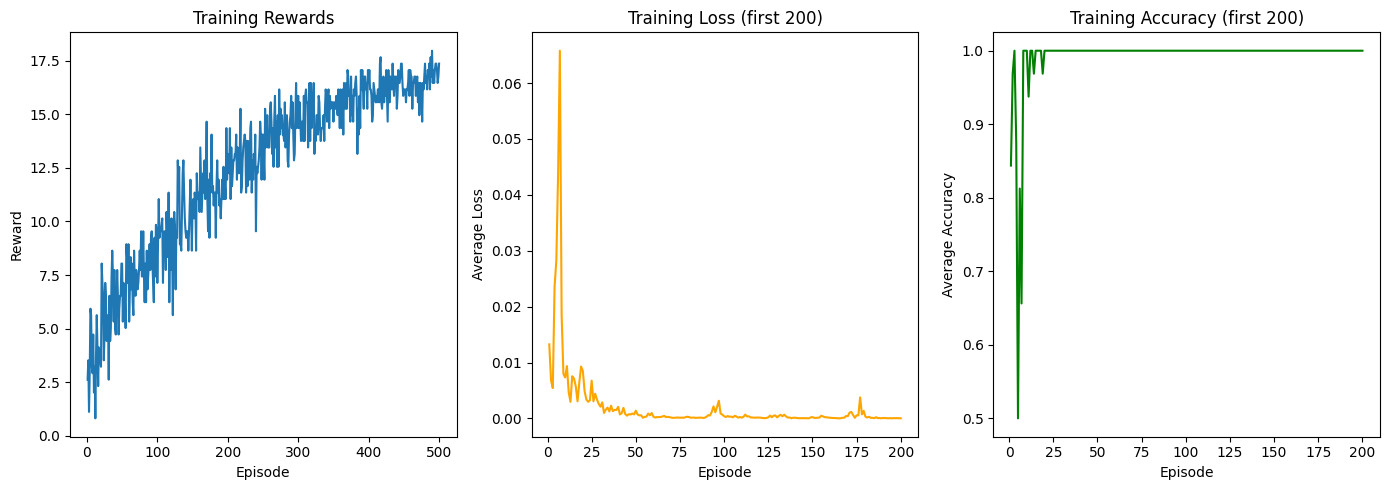

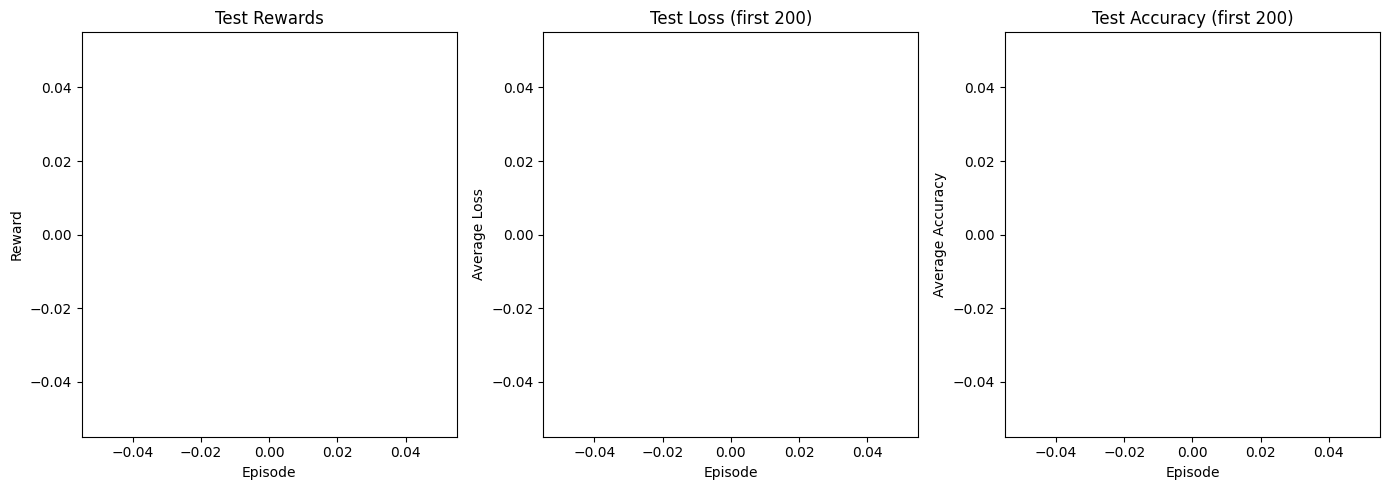

In [ ]:
def plot_metrics(rewards, loss, accuracy, title_prefix):
    episodes = range(1, len(rewards) + 1)
    plt.figure(figsize=(14, 5))

    # Plot rewards
    plt.subplot(1, 3, 1)
    plt.plot(episodes, rewards, label='Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'{title_prefix} Rewards')

    # Plot loss for the first 200 episodes
    plt.subplot(1, 3, 2)
    loss_per_episode = np.mean(np.array(loss[:200 * BATCH_SIZE]).reshape(-1, BATCH_SIZE), axis=1)
    plt.plot(range(1, len(loss_per_episode) + 1), loss_per_episode, label='Loss', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Average Loss')
    plt.title(f'{title_prefix} Loss (first 200)')

    # Plot accuracy for the first 200 episodes
    plt.subplot(1, 3, 3)
    accuracy_per_episode = np.mean(np.array(accuracy[:200 * BATCH_SIZE]).reshape(-1, BATCH_SIZE), axis=1)
    plt.plot(range(1, len(accuracy_per_episode) + 1), accuracy_per_episode, label='Accuracy', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title_prefix} Accuracy (first 200)')

    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower()}_metrics.png')
    plt.show()

# Plot and save training metrics with adjusted rewards
plot_metrics(adjusted_rewards, agent.loss_history, agent.accuracy_history, 'Training')

# Plot and save test metrics (assuming test_rewards are collected after testing)
plot_metrics(test_rewards, [0]*len(test_rewards), [0]*len(test_rewards), 'Test')
